In [8]:
import torch
import numpy as np
from src.model_utils import load_w2v_model, tokenize_sentence, word2idx, pad_sequence, load_word2vec_format, load_model
from src.RNNModelDetachedEmbeddings.data import load_data


'''val, test, train = load_data()

def convert_text_to_indices(text):
    tokenized_text = tokenize_sentence(text)

    return tokenized_text

w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embeddings = torch.nn.Embedding.from_pretrained(embedding_weights)

def integrated_gradients(model, input_text, baseline_text, text_lengths):
    # Convert input text to embeddings
    input_indices = convert_text_to_indices(input_text)
    input_embeddings = embeddings(input_indices)
    
    # Convert baseline text to embeddings
    baseline_indices = convert_text_to_indices(baseline_text)
    baseline_embeddings = embeddings(baseline_indices)
    
    # Compute gradients
    input_embeddings.requires_grad_()
    baseline_embeddings.requires_grad_()
    
    # Compute output predictions for input and baseline
    input_output = model(input_embeddings, text_lengths)
    baseline_output = model(baseline_embeddings, text_lengths)
    
    # Compute gradients
    gradients = torch.autograd.grad(input_output, input_embeddings)[0]
    
    # Compute integrated gradients
    integrated_gradients = (input_embeddings - baseline_embeddings) * gradients
    
    # Sum over embedding dimensions
    integrated_gradients = integrated_gradients.sum(dim=2)
    
    # Normalize
    normalization_factor = (input_embeddings - baseline_embeddings).sum(dim=2)
    normalized_integrated_gradients = integrated_gradients / normalization_factor
    
    # Return normalized integrated gradients
    return normalized_integrated_gradients

# Example usage
input_text = "This movie is great!"
baseline_text = "This movie is okay."
text_lengths = torch.tensor([4])  # Length of input_text

model = load_model('model')

integrated_grads = integrated_gradients(model, input_text, baseline_text, text_lengths)
print(integrated_grads)'''


'val, test, train = load_data()\n\ndef convert_text_to_indices(text):\n    tokenized_text = tokenize_sentence(text)\n\n    return tokenized_text\n\nw2v_model = load_word2vec_format(\n        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)\nembedding_weights = torch.FloatTensor(w2v_model.vectors)\nembeddings = torch.nn.Embedding.from_pretrained(embedding_weights)\n\ndef integrated_gradients(model, input_text, baseline_text, text_lengths):\n    # Convert input text to embeddings\n    input_indices = convert_text_to_indices(input_text)\n    input_embeddings = embeddings(input_indices)\n    \n    # Convert baseline text to embeddings\n    baseline_indices = convert_text_to_indices(baseline_text)\n    baseline_embeddings = embeddings(baseline_indices)\n    \n    # Compute gradients\n    input_embeddings.requires_grad_()\n    baseline_embeddings.requires_grad_()\n    \n    # Compute output predictions for input and baseline\n    input_output = model(input_embeddin

In [9]:
import torch
import numpy as np
from src.model_utils import load_w2v_model, tokenize_sentence, word2idx, pad_sequence, load_word2vec_format, load_model
from src.RNNModelDetachedEmbeddings.data import load_data

'''w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embeddings = torch.nn.Embedding.from_pretrained(embedding_weights)'''

'w2v_model = load_word2vec_format(\n        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)\nembedding_weights = torch.FloatTensor(w2v_model.vectors)\nembeddings = torch.nn.Embedding.from_pretrained(embedding_weights)'

In [10]:
'''from src.RNNModelDetachedEmbeddings.train import main

model = main()'''

'from src.RNNModelDetachedEmbeddings.train import main\n\nmodel = main()'

In [11]:
import torch
from src.model_utils import load_model, load_w2v_model, tokenize_sentence, word2idx, pad_sequence, load_word2vec_format, predict_single_text_DE



In [12]:
model = load_model('IMDB_DE_best_model')

w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embedding = torch.nn.Embedding.from_pretrained(embedding_weights)


In [16]:

device = torch.device("cpu")

text = "I love this movie. It's the best movie I've ever seen!"

print(predict_single_text_DE(text, model, device=device, model_type='IMDB', embedding=embedding))

1


In [68]:
import torch
import numpy as np

def integrated_gradients(input_text: str,
                         model: torch.nn.Module,
                         embedding: torch.nn.Embedding,
                         baseline_text: str = '',
                         num_steps: int = 50,
                         device: str = 'cpu') -> torch.Tensor:
    """
    Calculate integrated gradients for a given input text.

    Args:
        input_text (str): The input text for which to calculate the integrated gradients.
        model (torch.nn.Module): The model used for prediction.
        embedding (torch.nn.Embedding): The embedding layer to be applied to the input texts.
        baseline_text (str): The baseline text for the integrated gradients calculation.
        num_steps (int): Number of steps for numerical integration.
        device (str): The device to run the model on.

    Returns:
        torch.Tensor: Integrated gradients for each token in the input text.
    """

    # Tokenize input and baseline texts
    tokenized_input = tokenize_sentence(input_text)
    tokenized_baseline = tokenize_sentence(baseline_text) if baseline_text else ['the'] * len(tokenized_input)

    # Pad baseline text if necessary
    while len(tokenized_baseline) < len(tokenized_input):
        tokenized_baseline.append('the')

    # Convert tokens to indices
    input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)
    baseline_indices = torch.tensor(word2idx(w2v_model, tokenized_baseline)).unsqueeze(0).to(device)

    # Calculate difference between input and baseline embeddings
    input_embedding = embedding(input_indices)
    baseline_embedding = embedding(baseline_indices)
    diff = input_embedding - baseline_embedding

    # Generate interpolated inputs along the path from baseline to input
    interpolated_inputs = [baseline_embedding + (float(i) / num_steps) * diff for i in range(num_steps + 1)]
    interpolated_inputs = torch.cat(interpolated_inputs, dim=0)

    # Calculate gradients of outputs with respect to interpolated inputs
    interpolated_inputs.requires_grad_(True)
    model.to(device)
    model.eval()
    outputs = model(interpolated_inputs, torch.tensor([len(tokenized_input)]).to(device))

    # Calculate gradients for the single output tensor
    gradients = torch.autograd.grad(outputs=outputs, inputs=interpolated_inputs)[0]

    # Calculate integrated gradients
    integrated_gradients = torch.mean(gradients, dim=0)

    return integrated_gradients







In [69]:
# Assume you have already loaded your model and embedding as `model` and `embeddings` respectively
# Also, assuming `w2v_model` is available

# Example input text
input_text = "This movie is horrible! I hated it. It's the worst movie ever."


# Calculate integrated gradients
ig = integrated_gradients(input_text, model, embedding)

# Convert input text to tokens
tokenized_input = tokenize_sentence(input_text)

# Calculate absolute integrated gradients for each token
abs_ig = torch.abs(ig)

# Sort tokens based on their absolute integrated gradients (from highest to lowest)
sorted_indices = torch.argsort(abs_ig, descending=True)

# Print tokens along with their absolute integrated gradients
for i in range(len(tokenized_input)):
    token = tokenized_input[i]
    token_ig = abs_ig[i]
    print(f"Token: {token} - Absolute Integrated Gradient: {token_ig}")



tensor([[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]]) torch.Size([1, 12])
Token: This - Absolute Integrated Gradient: tensor([1.0109e-04, 4.3803e-05, 1.7296e-04, 5.5139e-05, 2.6919e-04, 2.4824e-04,
        4.9726e-05, 6.3463e-05, 2.9870e-05, 1.1922e-04, 1.8416e-04, 6.6117e-05,
        4.5113e-04, 2.4170e-04, 8.5571e-05, 1.6256e-05, 2.2532e-04, 2.8361e-04,
        1.4000e-04, 2.2366e-04, 5.8554e-05, 9.0176e-05, 1.2727e-04, 1.4009e-04,
        1.8637e-04, 3.6280e-04, 2.3120e-04, 8.0538e-05, 3.2674e-04, 6.8592e-05,
        2.2817e-05, 1.2541e-05, 1.5154e-04, 6.0023e-04, 6.4245e-05, 1.7619e-04,
        1.1269e-04, 5.1818e-04, 6.9952e-05, 1.9964e-04, 7.9426e-05, 1.2550e-04,
        3.9264e-04, 5.3871e-04, 4.4582e-05, 3.9866e-04, 2.3245e-05, 1.4947e-04,
        3.6846e-04, 1.4091e-04, 3.8045e-04, 2.1942e-04, 1.0718e-04, 1.4115e-04,
        2.5895e-04, 1.3363e-04, 6.5585e-05, 1.0769e-04, 1.5328e-04, 1.6996e-04,
        2.4860e-04, 2.2407e-04, 2.3877e-04, 1.1596e-04, 2.3845e-04, 4.6551e-0

C:\Users\cptad\AppData\Local\Temp\ipykernel_1276\3667147042.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)
C:\Users\cptad\AppData\Local\Temp\ipykernel_1276\3667147042.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_indices = torch.tensor(word2idx(w2v_model, tokenized_baseline)).unsqueeze(0).to(device)


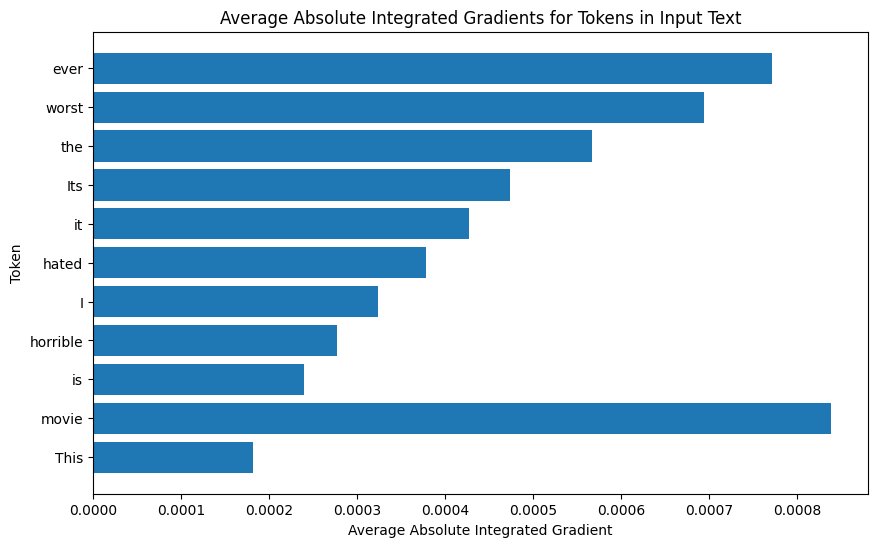

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays for plotting
token_labels = tokenized_input
ig_values = abs_ig.mean(dim=1).cpu().detach().numpy()

# Plot absolute integrated gradients
plt.figure(figsize=(10, 6))
plt.barh(token_labels, ig_values)
plt.xlabel('Average Absolute Integrated Gradient')
plt.ylabel('Token')
plt.title('Average Absolute Integrated Gradients for Tokens in Input Text')
plt.show()
